In [1293]:
import numpy as np 
import pandas as pd 

from sklearn import ensemble

from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate,GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import io
import os
import warnings
import re

# Loading data

In [1294]:
train = pd.read_csv("../downloads/titanic/train.csv")
test = pd.read_csv("../downloads/titanic/test.csv")
#removing a column that is not going to be used
train = train.drop(['PassengerId'], axis=1)
train = train.drop(['Ticket'], axis=1)
test = test.drop(['Ticket'], axis=1)
# train = train.drop(['Cabin'], axis=1)
# test = test.drop(['Cabin'], axis=1)
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,NaN,S


In [1295]:
train.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [1296]:
train.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Here we see that the average age is 29. In addition, the average fare is 32 yet the max is 512, because of this I'm going to take a look at outliers in this category and others to make sure they aren't affecting the models too much. 

# Data exploration and cleaning

In [1297]:
# fixing the ages that are not there

data = [train, test]
for dataset in data:
    mean = train["Age"].mean()
    std = test["Age"].std()
    is_null = dataset["Age"].isnull().sum()
    # compute random numbers between the mean, std and is_null
    rand_age = np.random.randint(mean - std, mean + std, size = is_null)
    # fill NaN values in Age column with random values generated
    age_slice = dataset["Age"].copy()
    age_slice[np.isnan(age_slice)] = rand_age
    dataset["Age"] = age_slice
    dataset["Age"] = train["Age"].astype(int)
train["Age"].isnull().sum()

0

<AxesSubplot:>

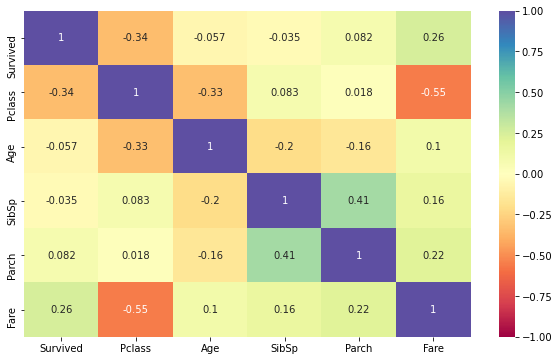

In [1298]:
plt.figure(figsize=(10,6))
sns.heatmap(train.corr(), vmax= 1, vmin= -1, cmap="Spectral",annot=True)

In [1299]:
train['Embarked'].describe()
# gets the most popular value

count     889
unique      3
top         S
freq      644
Name: Embarked, dtype: object

In [1300]:
# filling the missing value from embarked with most common
mode = 'S'
data = [train, test]

for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].fillna(mode)
train

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22,1,0,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26,0,0,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35,0,0,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...
886,0,2,"Montvila, Rev. Juozas",male,27,0,0,13.0000,NaN,S
887,1,1,"Graham, Miss. Margaret Edith",female,19,0,0,30.0000,B42,S
888,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,22,1,2,23.4500,NaN,S
889,1,1,"Behr, Mr. Karl Howell",male,26,0,0,30.0000,C148,C


In [1301]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       891 non-null    int64  
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Fare      891 non-null    float64
 8   Cabin     204 non-null    object 
 9   Embarked  891 non-null    object 
dtypes: float64(1), int64(5), object(4)
memory usage: 69.7+ KB


In [1302]:
data = [train, test]

for dataset in data:
    dataset['Fare'] = dataset['Fare'].fillna(0)
    dataset['Fare'] = dataset['Fare'].astype(int)

In [1303]:
train['Sex'] = train['Sex'].map({'male': 0,'female': 1})
test['Sex'] = test['Sex'].map({'male': 0,'female': 1})
train

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",0,22,1,0,7,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38,1,0,71,C85,C
2,1,3,"Heikkinen, Miss. Laina",1,26,0,0,7,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35,1,0,53,C123,S
4,0,3,"Allen, Mr. William Henry",0,35,0,0,8,NaN,S
...,...,...,...,...,...,...,...,...,...,...
886,0,2,"Montvila, Rev. Juozas",0,27,0,0,13,NaN,S
887,1,1,"Graham, Miss. Margaret Edith",1,19,0,0,30,B42,S
888,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",1,22,1,2,23,NaN,S
889,1,1,"Behr, Mr. Karl Howell",0,26,0,0,30,C148,C


In [1304]:
train['Embarked'] = train['Embarked'].map({'S': 0,'C': 1, 'Q': 2})
test['Embarked'] = test['Embarked'].map({'S': 0,'C': 1, 'Q': 2})
train

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",0,22,1,0,7,NaN,0
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38,1,0,71,C85,1
2,1,3,"Heikkinen, Miss. Laina",1,26,0,0,7,NaN,0
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35,1,0,53,C123,0
4,0,3,"Allen, Mr. William Henry",0,35,0,0,8,NaN,0
...,...,...,...,...,...,...,...,...,...,...
886,0,2,"Montvila, Rev. Juozas",0,27,0,0,13,NaN,0
887,1,1,"Graham, Miss. Margaret Edith",1,19,0,0,30,B42,0
888,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",1,22,1,2,23,NaN,0
889,1,1,"Behr, Mr. Karl Howell",0,26,0,0,30,C148,1


<Figure size 1440x864 with 0 Axes>

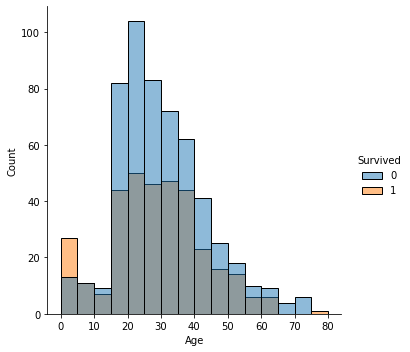

In [1305]:
plt.figure(figsize=(20,12))
sns.displot(train, x="Age", binwidth=5, hue = 'Survived')

Can see patterns in the age that when the age is less than five the survival rate it higher, similar to when it's above 75. Because of this we will want to make sure that those individuals are being grouped together. We also see that the mortality rate jumps tremedously when the age passes 15.

In [1306]:
data = [train, test]
for dataset in data:
    dataset['Age'] = dataset['Age'].astype(int)
    dataset.loc[ dataset['Age'] <= 5, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 5) & (dataset['Age'] <= 10), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 10) & (dataset['Age'] <= 15), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 15) & (dataset['Age'] <= 20), 'Age'] = 3
    dataset.loc[(dataset['Age'] > 20) & (dataset['Age'] <= 25), 'Age'] = 4
    dataset.loc[(dataset['Age'] > 25) & (dataset['Age'] <= 30), 'Age'] = 5
    dataset.loc[(dataset['Age'] > 30) & (dataset['Age'] <= 35), 'Age'] = 6
    dataset.loc[(dataset['Age'] > 35) & (dataset['Age'] <= 40), 'Age'] = 7
    dataset.loc[(dataset['Age'] > 40) & (dataset['Age'] <= 45), 'Age'] = 8
    dataset.loc[(dataset['Age'] > 45) & (dataset['Age'] <= 50), 'Age'] = 9
    dataset.loc[(dataset['Age'] > 50) & (dataset['Age'] <= 65), 'Age'] = 10
    dataset.loc[(dataset['Age'] > 65) & (dataset['Age'] <= 75), 'Age'] = 11
    dataset.loc[ dataset['Age'] > 75, 'Age'] = 12

train['Age'].value_counts()

4     156
3     138
5     135
6     118
7      98
8      56
10     56
0      44
9      37
2      25
1      20
11      7
12      1
Name: Age, dtype: int64

<Figure size 1440x864 with 0 Axes>

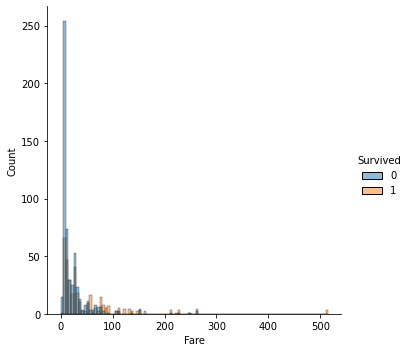

In [1307]:
plt.figure(figsize=(20,12))
sns.displot(train, x="Fare", binwidth=5, hue = 'Survived')

Here we can see an outlier of a high fare so I'll want to have that be it's own category. In addition, we see a trend where the cheaper the fare the higher the distribution of deaths there was. 

In [1308]:
# cutting the fare category into seven categories to see a better distribution
pd.qcut(train['Fare'], q=7)

0      (-0.001, 7.0]
1      (56.0, 512.0]
2      (-0.001, 7.0]
3       (27.0, 56.0]
4         (7.0, 8.0]
           ...      
886     (12.0, 19.0]
887     (27.0, 56.0]
888     (19.0, 27.0]
889     (27.0, 56.0]
890    (-0.001, 7.0]
Name: Fare, Length: 891, dtype: category
Categories (7, interval[float64]): [(-0.001, 7.0] < (7.0, 8.0] < (8.0, 12.0] < (12.0, 19.0] < (19.0, 27.0] < (27.0, 56.0] < (56.0, 512.0]]

In [1309]:
# changes the fare to groupings and changes the sex to a quantitative variable
data = [train, test]

for dataset in data:
    dataset['Fare'] = dataset['Fare'].fillna(0)
    dataset.loc[ dataset['Fare'] <= 7, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7) & (dataset['Fare'] <= 8), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 8) & (dataset['Fare'] <= 12), 'Fare']   = 2
    dataset.loc[(dataset['Fare'] > 12) & (dataset['Fare'] <= 19), 'Fare']   = 3
    dataset.loc[(dataset['Fare'] > 19) & (dataset['Fare'] <= 27), 'Fare']   = 4
    dataset.loc[(dataset['Fare'] > 27) & (dataset['Fare'] <= 56), 'Fare']   = 5
    dataset.loc[(dataset['Fare'] > 56) & (dataset['Fare'] <= 100), 'Fare']   = 6
    dataset.loc[(dataset['Fare'] > 100) & (dataset['Fare'] <= 300), 'Fare']   = 7
    dataset.loc[ dataset['Fare'] > 300, 'Fare'] = 8
    
    dataset.loc[ dataset['Sex'] == "female"] = 1
    dataset.loc[dataset['Sex'] == "male"] = 0
    
    dataset['Sex'] = dataset['Sex'].astype(int)
    dataset['Fare'] = dataset['Fare'].astype(int)

In [1310]:
# changes deck to a quantitative variable and fills NAs with 0
import re
deck = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "U": 8}
data = [train, test]

for dataset in data:
    dataset['Cabin'] = dataset['Cabin'].fillna("U0")
    dataset['Deck'] = dataset['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
    dataset['Deck'] = dataset['Deck'].map(deck)
    dataset['Deck'] = dataset['Deck'].fillna(0)
    dataset['Deck'] = dataset['Deck'].astype(int)
# we can now drop the cabin feature
train = train.drop(['Cabin'], axis=1)
test = test.drop(['Cabin'], axis=1)

In [1311]:
data = [train, test]
for dataset in data:
    dataset['relatives'] = dataset['SibSp'] + dataset['Parch']
    dataset.loc[dataset['relatives'] > 0, 'not_alone'] = 0
    dataset.loc[dataset['relatives'] == 0, 'not_alone'] = 1
    dataset['not_alone'] = dataset['not_alone'].astype(int)

train = train.drop(['SibSp'], axis=1)
test = test.drop(['SibSp'], axis=1)
train = train.drop(['Parch'], axis=1)
test = test.drop(['Parch'], axis=1)

/Users/claremcauliffe/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/Users/claremcauliffe/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


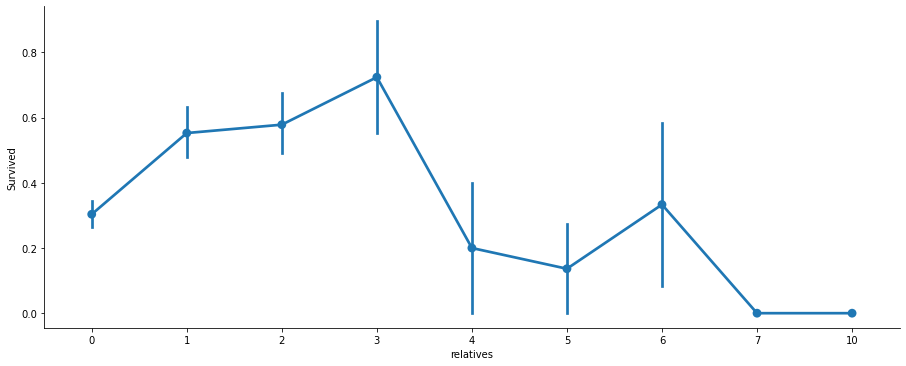

In [1312]:
axes = sns.factorplot('relatives','Survived', 
                      data=train, aspect = 2.5, )

This plot helps us see that those with less than one family member had a lower chance of surviving, those with 1-3 or 6 had a better chance, and anything else had a lower chance of surviving.

In [1313]:
# gets the first part of a name and categorizes it to be an interger
data = [train, test]
titles = {"Mr": 1, "Mrs": 2, "Miss": 3, "Unique": 4, "Master" : 5}

for dataset in data:
    # extract titles
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    # replace titles with a more common title or as Unique
    dataset['Title'] = dataset['Title'].replace(['Dr','Sir', 'Capt'], 'Unique')
    dataset['Title'] = dataset['Title'].replace(['Master'], 'Master')
    dataset['Title'] = dataset['Title'].replace(['Mlle','Ms','Lady','Dona'], 'Miss')
    dataset['Title'] = dataset['Title'].replace(['Don', 'Major', 'Jonkheer', 'Rev', 'Col'], 'Mr')
    dataset['Title'] = dataset['Title'].replace(['Mme','Countess'], 'Mrs')
    # convert titles into numbers
    dataset['Title'] = dataset['Title'].map(titles)
    # filling NaN with 0, to get safe
    dataset['Title'] = dataset['Title'].fillna(0)
    
train = train.drop(['Name'], axis=1)
test = test.drop(['Name'], axis=1)

<AxesSubplot:xlabel='Title', ylabel='Count'>

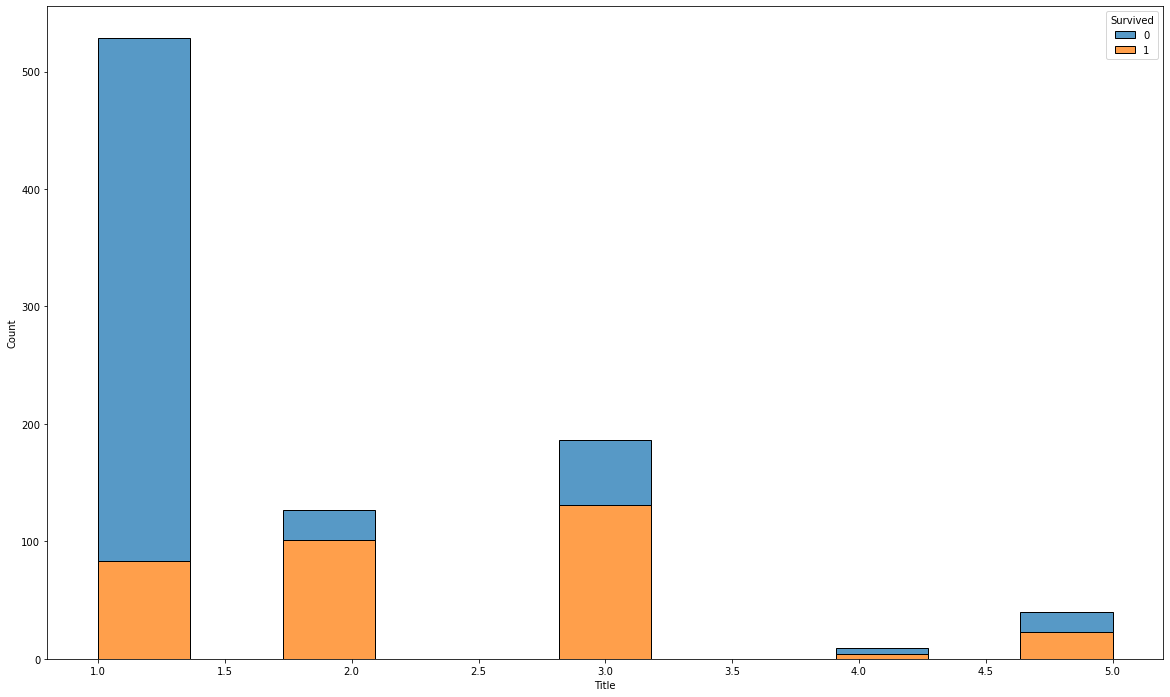

In [1314]:
plt.figure(figsize=(20,12))
sns.histplot(data=train, x="Title", hue="Survived", multiple="stack")

Here we can see that the people with a title mr had a lower chance of surviving, while the women (so miss or mrs) had a higher chance of survival. We also see that the unique titles have closer to a 50, 50 chance.

In [1315]:
# seeing both the dataset to make sure they're the same formating and have all the quantitative data 
train

,Survived,Pclass,Sex,Age,Fare,Embarked,Deck,relatives,not_alone,Title
0,0,3,0,4,0,0,8,1,0,1
1,1,1,1,7,6,1,3,1,0,2
2,1,3,1,5,0,0,8,0,1,3
3,1,1,1,6,5,0,3,1,0,2
4,0,3,0,6,1,0,8,0,1,1
...,...,...,...,...,...,...,...,...,...,...
886,0,2,0,5,3,0,8,0,1,1
887,1,1,1,3,5,0,2,0,1,3
888,0,3,1,4,4,0,8,3,0,3
889,1,1,0,5,5,1,3,0,1,1


In [1316]:
test

,PassengerId,Pclass,Sex,Age,Fare,Embarked,Deck,relatives,not_alone,Title
0,892,3,0,4,0,2,8,0,1,1
1,893,3,1,7,0,0,8,1,0,2
2,894,2,0,5,2,2,8,0,1,1
3,895,3,0,6,1,0,8,0,1,1
4,896,3,1,6,2,0,8,2,0,2
...,...,...,...,...,...,...,...,...,...,...
413,1305,3,0,5,1,0,8,0,1,1
414,1306,1,1,8,7,1,3,0,1,3
415,1307,3,0,3,0,0,8,0,1,1
416,1308,3,0,6,1,0,8,0,1,1


# Creating the models and testing for accuracy

In [1317]:
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [1318]:
names = ["Logistical Regression","Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes"]

classifiers = [
    LogisticRegression(),
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier( n_estimators=50),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    ]

In [1319]:

from sklearn.model_selection import train_test_split
# "target" contains the column name of the classification labels
target = "Survived"

X = train.drop(target,1)
y = train[target]

seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

In [1320]:
for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    # evaluate predictions
    accuracy = clf.score(X_test, y_test)
    print("%s Accuracy: %.2f%%" % (name,accuracy * 100.0))

Logistical Regression Accuracy: 80.34%
Nearest Neighbors Accuracy: 73.56%
Linear SVM Accuracy: 76.61%
RBF SVM Accuracy: 62.37%
Gaussian Process Accuracy: 80.34%
Decision Tree Accuracy: 82.03%
Random Forest Accuracy: 78.64%
Neural Net Accuracy: 79.32%
AdaBoost Accuracy: 80.00%
Naive Bayes Accuracy: 76.95%


In [1321]:
X_train = train.drop("Survived", axis=1)
Y_train = train["Survived"]
X_test  = test.drop("PassengerId", axis=1).copy()

In [1322]:
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)

Y_pred = logreg.predict(X_test)

acc_log = round(logreg.score(X_train, Y_train) * 100, 2)
acc_log

81.93

In [1323]:
dec_tree = DecisionTreeClassifier(max_depth=5)
dec_tree.fit(X_train, Y_train)

Y_prediction = dec_tree.predict(X_test)

dec_tree.score(X_train, Y_train)
acc_dec_tree = round(dec_tree.score(X_train, Y_train) * 100, 2)
acc_dec_tree

85.52

In [1324]:
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)

Y_prediction = random_forest.predict(X_test)

random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
acc_random_forest

93.27

In [1325]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
predictions = cross_val_predict(random_forest, X_train, Y_train, cv=3)
confusion_matrix(Y_train, predictions)

array([[471,  78],
       [101, 241]])

# Predicting to the test

In [1326]:
# this was getting me a .75 then a 66 with removing lower accuracy scoring ones so I decided to go with 
# a different approach



# clf1 = LogisticRegression()
# clf2 = RandomForestClassifier(n_estimators=100)
# # clf3 = KNeighborsClassifier(3)
# # had a low accuracy so I removed it 
# # clf4 = SVC(kernel="linear", C=0.025)
# clf5 = GaussianProcessClassifier(1.0 * RBF(1.0))
# clf6 = DecisionTreeClassifier(max_depth=5)
# clf8 = MLPClassifier(alpha=1, max_iter=1000)
# clf9 = AdaBoostClassifier()
# clf10 = GaussianNB()

# eclf1 = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2),('GAUS', clf5),('DTC', clf6),
#                                 ('MLP', clf8),('ADA', clf9),('GNB', clf10)], voting='hard')
# eclf1 = eclf1.fit(X_train, Y_train)
# predictions= (eclf1.predict(X_test))
# output = pd.DataFrame({'PassengerId': test.PassengerId, 'Survived': predictions})

# output.to_csv('submission.csv', index=False)
# print('Output shape:', output.shape)
# print("Your submission was successfully saved!")
# predictions

In [1327]:
test_copy = test.drop(['PassengerId'], axis = 1)

# getting me a .76
# predictions = random_forest.predict(test_copy)


# getting me a .77
# predictions = logreg.predict(test_copy)

# gave me highest of a .78
predictions = dec_tree.predict(test_copy)
output = pd.DataFrame({'PassengerId': test.PassengerId, 'Survived': predictions})
output
output.to_csv('submission.csv', index=False)
print('Output shape:', output.shape)
print("Your submission was successfully saved!")
predictions

Output shape: (418, 2)
Your submission was successfully saved!


array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,